# YAPAY ZEKİLER - TAU TAGGING - HAMİD ENES CENGİZ

**Main Objective:** To analyze datasets using machine learning to separate hadronic tau decays from the background signals.

**Active area of work:** ParticleNet

#### Benchmark

In [2]:
import pandas as pd

df = pd.read_csv(r"C:\Users\jirai\OneDrive\particleNet_benchmark_results.csv")
df.head()


,Model,Accuracy,AUC,1/εb @ εs=50%,1/εb @ εs=30%
0,ResNeXt-50,0.936,0.9837,302,1147
1,P-CNN,0.930,0.9803,201,759
2,PFN,NaN,0.9819,247,888
3,ParticleNet-Lite,0.937,0.9844,325,1262
4,ParticleNet,0.940,0.9858,397,1615


- Receiver Operating Characteristic (ROC) curve: Shows the classification performance of the model.
- AUC (Area Under Curve): The area under the curve measures the model's success.
- Background Rejection Rate (1/εb):

The model shows how successfully it rejects the background at a given signal efficiency (e.g., 30% or 50%).

### Code: Model Trainig(Future Dataset)

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import time
from tqdm import tqdm

# EdgeConv katmanı
class EdgeConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EdgeConv, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels * 2, out_channels),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )

    def forward(self, x, batch_size):
        n_particles = x.size(1)
        x_i = x.unsqueeze(2).expand(-1, -1, n_particles, -1)
        x_j = x.unsqueeze(1).expand(-1, n_particles, -1, -1)
        edge_features = torch.cat([x_i, x_j - x_i], dim=-1)
        edge_features = edge_features.view(-1, edge_features.size(-1))
        edge_features = self.mlp(edge_features)
        edge_features = edge_features.view(batch_size, n_particles, n_particles, -1)
        return edge_features.max(dim=2)[0]

# ParticleNet modeli
class ParticleNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ParticleNet, self).__init__()
        self.edge_conv1 = EdgeConv(input_dim, 32)
        self.edge_conv2 = EdgeConv(32, 64)
        self.fc1 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(64, num_classes)
        self.bn1 = nn.BatchNorm1d(64)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.edge_conv1(x, batch_size)
        x = self.edge_conv2(x, batch_size)
        x = x.max(dim=1)[0]
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Cihaz seçimi (GPU veya CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA Kullanılabilir mi? {torch.cuda.is_available()}")

# Veri yükleme
train_data = pd.read_parquet(r'C:\Users\jirai\OneDrive\z_train.parquet').head(1000)
test_data = pd.read_parquet(r'C:\Users\jirai\OneDrive\z_test.parquet').head(200)

# reco_jet_p4s sütunlarını genişletme
train_data_reco_jet_df = pd.DataFrame(train_data['reco_jet_p4s'].tolist())
test_data_reco_jet_df = pd.DataFrame(test_data['reco_jet_p4s'].tolist())

train_data = pd.concat([train_data, train_data_reco_jet_df], axis=1)
test_data = pd.concat([test_data, test_data_reco_jet_df], axis=1)

# Etiket ve özellikler
label_column = 'gen_jet_tau_decaymode'
feature_columns = train_data_reco_jet_df.columns.tolist()

# Özellik ve etiketleri seç
X_train = train_data[feature_columns].values
y_train = train_data[label_column].values
X_test = test_data[feature_columns].values
y_test = test_data[label_column].values

# Sınıf etiketlerini yeniden numaralandır
all_labels = np.unique(np.concatenate([y_train, y_test]))
label_map = {old_label: new_label for new_label, old_label in enumerate(all_labels)}

y_train = np.array([label_map[label] for label in y_train])
y_test = np.array([label_map[label] for label in y_test])

print("Updated train labels:", np.unique(y_train))
print("Updated test labels:", np.unique(y_test))

# Padding
def pad_particles(data, max_particles=100):
    padded_data = np.zeros((len(data), max_particles, data.shape[-1]))
    for i, jet in enumerate(data):
        jet_len = min(len(jet), max_particles)
        padded_data[i, :jet_len, :] = jet[:jet_len]
    return padded_data

X_train_padded = pad_particles(X_train)
X_test_padded = pad_particles(X_test)

# Normalize etme
scaler = StandardScaler()
X_train_flat = X_train_padded.reshape(-1, X_train_padded.shape[-1])
X_test_flat = X_test_padded.reshape(-1, X_test_padded.shape[-1])

X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

X_train_norm = X_train_flat.reshape(X_train_padded.shape)
X_test_norm = X_test_flat.reshape(X_test_padded.shape)

# Tensor dönüştürme
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Model
num_classes = len(all_labels)  # Yeni sınıf sayısına göre ayarlandı
model = ParticleNet(input_dim=X_train_tensor.shape[-1], num_classes=num_classes)
model.to(device)

# Eğitim
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(2):
    model.train()
    for X_batch, y_batch in tqdm(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

# Test
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

print(f"Accuracy: {100 * correct / total:.2f}%")


CUDA Kullanılabilir mi? False
Updated train labels: [0 1 2 3 4 5 6 7 8]
Updated test labels: [0 1 2 3 5 6 7]


100%|██████████| 125/125 [00:13<00:00,  9.07it/s]


Accuracy: 40.00%


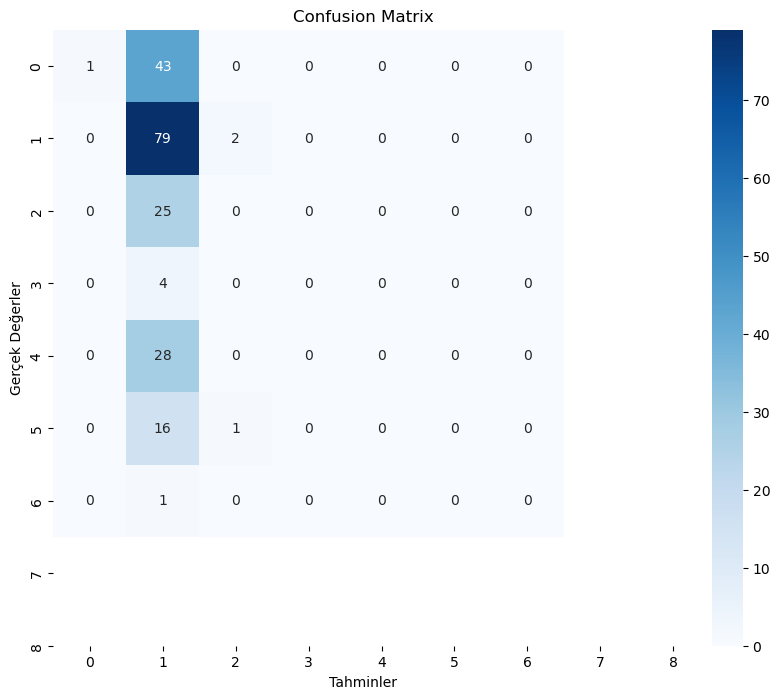

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Modeli değerlendirme ve tahminleri alma
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Confusion Matrix hesaplama
cm = confusion_matrix(y_true, y_pred)

# Görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Tahminler')
plt.ylabel('Gerçek Değerler')
plt.title('Confusion Matrix')
plt.show()


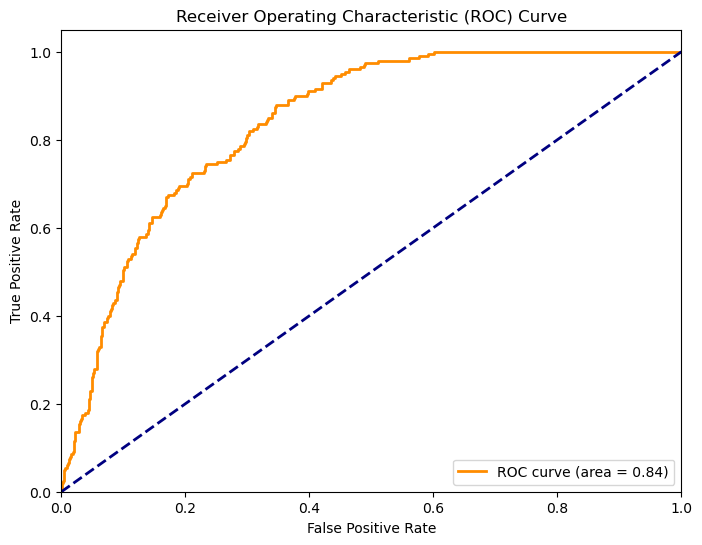

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Gerçek etiketleri binary formatta dönüştürme
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))

# Modeli değerlendirme ve ROC eğrisini çizme
y_pred_prob = model(X_test_tensor).detach().cpu().numpy()  # Modelin çıktısını alıyoruz ve NumPy dizisine çeviriyoruz

# ROC curve hesaplama
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc = auc(fpr, tpr)

# ROC eğrisini çizme
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


100%|██████████| 125/125 [00:15<00:00,  8.23it/s]


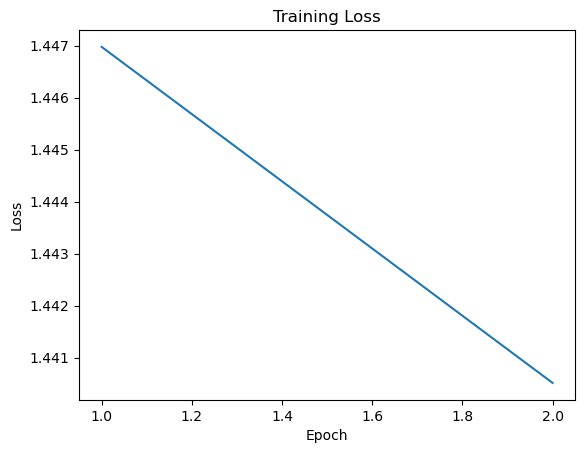

In [18]:
# Eğitim kayıplarını kaydetme
train_losses = []

for epoch in range(2):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in tqdm(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

# Kayıp eğrisini çizme
plt.plot(range(1, len(train_losses) + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import time
from tqdm import tqdm

# EdgeConv katmanı
class EdgeConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EdgeConv, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels * 2, out_channels),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )

    def forward(self, x, batch_size):
        n_particles = x.size(1)
        x_i = x.unsqueeze(2).expand(-1, -1, n_particles, -1)
        x_j = x.unsqueeze(1).expand(-1, n_particles, -1, -1)
        edge_features = torch.cat([x_i, x_j - x_i], dim=-1)
        edge_features = edge_features.view(-1, edge_features.size(-1))
        edge_features = self.mlp(edge_features)
        edge_features = edge_features.view(batch_size, n_particles, n_particles, -1)
        return edge_features.max(dim=2)[0]

# ParticleNet modeli
class ParticleNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ParticleNet, self).__init__()
        self.edge_conv1 = EdgeConv(input_dim, 32)
        self.edge_conv2 = EdgeConv(32, 64)
        self.fc1 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(64, num_classes)
        self.bn1 = nn.BatchNorm1d(64)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.edge_conv1(x, batch_size)
        x = self.edge_conv2(x, batch_size)
        x = x.max(dim=1)[0]
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Cihaz seçimi (GPU veya CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA Kullanılabilir mi? {torch.cuda.is_available()}")

# Veri yükleme
train_data = pd.read_parquet(r'C:\Users\jirai\OneDrive\z_train.parquet').head(1000)
test_data = pd.read_parquet(r'C:\Users\jirai\OneDrive\z_test.parquet').head(200)

# reco_jet_p4s sütunlarını genişletme
train_data_reco_jet_df = pd.DataFrame(train_data['reco_jet_p4s'].tolist())
test_data_reco_jet_df = pd.DataFrame(test_data['reco_jet_p4s'].tolist())

train_data = pd.concat([train_data, train_data_reco_jet_df], axis=1)
test_data = pd.concat([test_data, test_data_reco_jet_df], axis=1)

# Etiket ve özellikler
label_column = 'gen_jet_tau_decaymode'
feature_columns = train_data_reco_jet_df.columns.tolist()

# Özellik ve etiketleri seçme
X_train = train_data[feature_columns].values
y_train = train_data[label_column].values
X_test = test_data[feature_columns].values
y_test = test_data[label_column].values

# Etiketleri ikili sınıfa dönüştür
y_train_binary = np.where(y_train == 0, 0, 1)
y_test_binary = np.where(y_test == 0, 0, 1)

# Padding
def pad_particles(data, max_particles=100):
    padded_data = np.zeros((len(data), max_particles, data.shape[-1]))
    for i, jet in enumerate(data):
        jet_len = min(len(jet), max_particles)
        padded_data[i, :jet_len, :] = jet[:jet_len]
    return padded_data

X_train_padded = pad_particles(X_train)
X_test_padded = pad_particles(X_test)

# Normalize etme
scaler = StandardScaler()
X_train_flat = X_train_padded.reshape(-1, X_train_padded.shape[-1])
X_test_flat = X_test_padded.reshape(-1, X_test_padded.shape[-1])

X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

X_train_norm = X_train_flat.reshape(X_train_padded.shape)
X_test_norm = X_test_flat.reshape(X_test_padded.shape)

# Tensor dönüştürme
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_binary, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_binary, dtype=torch.long)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Model
model = ParticleNet(input_dim=X_train_tensor.shape[-1], num_classes=2)
model.to(device)

# Eğitim
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(2):
    model.train()
    for X_batch, y_batch in tqdm(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

# Test
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

print(f"Binary Classification Accuracy: {100 * correct / total:.2f}%")


CUDA Kullanılabilir mi? False


100%|██████████| 125/125 [00:15<00:00,  8.30it/s]


Binary Classification Accuracy: 78.00%
